# 05. Logistic regression

In [156]:
# Install a conda package in the current Jupyter kernel
# xlrd package needs to be installed for pandas to open Excel files
import sys
! conda install --yes --prefix {sys.prefix} xlrd
! conda install --yes --prefix {sys.prefix} lxml

Solving environment: ...working... done

# All requested packages already installed.

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\ProgramData\Miniconda3

  added / updated specs:
    - lxml


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    libiconv-1.16              |       he774522_0         680 KB  conda-forge
    libxml2-2.9.10             |       h1006b36_2         3.5 MB  conda-forge
    libxslt-1.1.33             |       h579f668_1         499 KB  conda-forge
    lxml-4.5.2                 |   py38he3d0fc9_1         1.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         5.7 MB

The following NEW packages will be INSTALLED:

  libiconv           conda-forge/win-64::libiconv-1.16-he774522_0
  libxml2            conda-forge/win-64::libxml2-2.9.10-h1006b36

In [2]:
import os
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

from IPython.display import display

In [3]:
data = './data/'
out = './out/'

# Bold print for Jupyter Notebook
b1 = '\033[1m'
b0 = '\033[0m'

### Just some matplotlib and seaborn parameter tuning

In [4]:
axistitlesize = 20
axisticksize = 17
axislabelsize = 26
axislegendsize = 23
axistextsize = 20
axiscbarfontsize = 15

# Set axtick dimensions
major_size = 6
major_width = 1.2
minor_size = 3
minor_width = 1
mpl.rcParams['xtick.major.size'] = major_size
mpl.rcParams['xtick.major.width'] = major_width
mpl.rcParams['xtick.minor.size'] = minor_size
mpl.rcParams['xtick.minor.width'] = minor_width
mpl.rcParams['ytick.major.size'] = major_size
mpl.rcParams['ytick.major.width'] = major_width
mpl.rcParams['ytick.minor.size'] = minor_size
mpl.rcParams['ytick.minor.width'] = minor_width

mpl.rcParams.update({'figure.autolayout': False})

# Seaborn style settings
sns.set_style({'axes.axisbelow': True,
               'axes.edgecolor': '.8',
               'axes.facecolor': 'white',
               'axes.grid': True,
               'axes.labelcolor': '.15',
               'axes.spines.bottom': True,
               'axes.spines.left': True,
               'axes.spines.right': True,
               'axes.spines.top': True,
               'figure.facecolor': 'white',
               'font.family': ['sans-serif'],
               'font.sans-serif': ['Arial',
                'DejaVu Sans',
                'Liberation Sans',
                'Bitstream Vera Sans',
                'sans-serif'],
               'grid.color': '.8',
               'grid.linestyle': '--',
               'image.cmap': 'rocket',
               'lines.solid_capstyle': 'round',
               'patch.edgecolor': 'w',
               'patch.force_edgecolor': True,
               'text.color': '.15',
               'xtick.bottom': True,
               'xtick.color': '.15',
               'xtick.direction': 'in',
               'xtick.top': True,
               'ytick.color': '.15',
               'ytick.direction': 'in',
               'ytick.left': True,
               'ytick.right': True})

# Colorpalettes, colormaps, etc.
sns.set_palette(palette='rocket')

## 1. Download data from https://science.sciencemag.org/content/359/6378/926 (supplementary materials). If you do not succeed, you will find _aar3247_Cohen_SM_Tables-S1-S11.xlsx_ file in the homework's folder.
 - read the abstract of the article to get familiar with data origin
 - open the data in excel and get familiar with its content
 - load the protein level data (you need to figure out which one is that) as a pandas dataframe
 - handle missing values and convert features to numeric values when it is needed
 - get rid of the unnecessary (which does not encode protein levels or the tumor type) columns and the CancerSEEK results

### 1./a. Open the protein dataset

#### Open file from URL

In [5]:
#import urllib.request

### Issue

Pandas somewhy can't handle I/O with excel files, when loading them from an `urllib3.response.HTTPResponse` object:

- [Issue #20434](https://github.com/pandas-dev/pandas/issues/20434)
- [Issue #28825](https://github.com/pandas-dev/pandas/issues/28825)

It was said to be adressed in [Issue #28874](https://github.com/pandas-dev/pandas/pull/28874), but it seems that it wasn't, or maybe it was reintroduced in a newer release. At the end of the day this code simply doesn't work, however it should in normal circumstances.

In [6]:
# PANDAS BUG!
#url = 'https://science.sciencemag.org/highwire/filestream/704651/field_highwire_adjunct_files/1/aar3247_Cohen_SM_Tables-S1-S11.xlsx'
#with urllib.request.urlopen(url) as url:
#    df = pd.read_excel(url)

#### Open file locally

Open file using the local download

In [7]:
os.listdir(data)

['aar3247_Cohen_SM_Tables-S1-S11.xlsx',
 '~$aar3247_Cohen_SM_Tables-S1-S11.xlsx']

In [8]:
df = pd.read_excel(data + 'aar3247_Cohen_SM_Tables-S1-S11.xlsx', sheet_name='Table S6', header=2)

In [9]:
display(df.head())
display(df.tail())

,Patient ID #,Sample ID #,Tumor type,AJCC Stage,AFP (pg/ml),Angiopoietin-2 (pg/ml),AXL (pg/ml),CA-125 (U/ml),CA 15-3 (U/ml),CA19-9 (U/ml),...,sFas (pg/ml),SHBG (nM),sHER2/sEGFR2/sErbB2 (pg/ml),sPECAM-1 (pg/ml),TGFa (pg/ml),Thrombospondin-2 (pg/ml),TIMP-1 (pg/ml),TIMP-2 (pg/ml),CancerSEEK Logistic Regression Score,CancerSEEK Test Result
0,CRC 455,CRC 455 PLS 1,Colorectum,I,1583.45,5598.5,3621.04,5.09,19.08,*16.452,...,*204.792,55.06,6832.07,9368.53,*16.086,21863.7,56428.7,39498.82,0.938342,Positive
1,CRC 456,CRC 456 PLS 1,Colorectum,I,*715.308,20936.3,2772.96,7.27,10.04,40.91,...,*204.792,72.92,5549.47,6224.55,*16.086,29669.7,73940.5,41277.09,0.925363,Positive
2,CRC 457,CRC 457 PLS 1,Colorectum,II,4365.53,2350.93,4120.77,*4.854,16.96,*16.452,...,*204.792,173.78,3698.16,4046.48,179.03,6020.47,22797.3,28440.60,0.852367,Negative
3,CRC 458,CRC 458 PLS 1,Colorectum,II,*715.308,1604.34,2029.96,5.39,8.31,*16.452,...,*204.792,29.47,5856,6121.93,*16.086,4331.02,20441.2,25896.73,0.617639,Negative
4,CRC 459,CRC 459 PLS 1,Colorectum,II,801.3,2087.57,2069.17,*4.854,11.73,*16.452,...,*204.792,78.07,5447.93,6982.32,*16.086,2311.91,56288.5,49425.20,0.318434,Negative


,Patient ID #,Sample ID #,Tumor type,AJCC Stage,AFP (pg/ml),Angiopoietin-2 (pg/ml),AXL (pg/ml),CA-125 (U/ml),CA 15-3 (U/ml),CA19-9 (U/ml),...,sFas (pg/ml),SHBG (nM),sHER2/sEGFR2/sErbB2 (pg/ml),sPECAM-1 (pg/ml),TGFa (pg/ml),Thrombospondin-2 (pg/ml),TIMP-1 (pg/ml),TIMP-2 (pg/ml),CancerSEEK Logistic Regression Score,CancerSEEK Test Result
1816,PAPA 1357,PAPA 1357 PLS 1,Ovary,III,*879.498,3546.43,1493.32,1428.31,**836.85,37.9,...,*207.24,72.22,3967.55,4045.18,*16.89,12877.1,88464,47219.24,1.0,Positive
1817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1818,*Protein concentration below the limit of dete...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1819,**Protein concentration above the limit of det...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1820,NA: Not available,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# last 4 columns are just comments
df = df.iloc[:-4]

In [11]:
display(df.tail())

,Patient ID #,Sample ID #,Tumor type,AJCC Stage,AFP (pg/ml),Angiopoietin-2 (pg/ml),AXL (pg/ml),CA-125 (U/ml),CA 15-3 (U/ml),CA19-9 (U/ml),...,sFas (pg/ml),SHBG (nM),sHER2/sEGFR2/sErbB2 (pg/ml),sPECAM-1 (pg/ml),TGFa (pg/ml),Thrombospondin-2 (pg/ml),TIMP-1 (pg/ml),TIMP-2 (pg/ml),CancerSEEK Logistic Regression Score,CancerSEEK Test Result
1812,PAPA 1353,PAPA 1353 PLS 1,Ovary,I,*879.498,1484.7,2096.76,24.82,10.3,42.39,...,*207.24,115.24,5390.31,8538.58,*16.89,*599.4,167800,50128.60,0.980312,Positive
1813,PAPA 1354,PAPA 1354 PLS 1,Ovary,I,1337.33,1607.9,852.37,5.58,9.8,*16.44,...,*207.24,147.17,7951.03,12966.19,*16.89,*599.4,123444,54066.98,0.999995,Positive
1814,PAPA 1355,PAPA 1355 PLS 1,Ovary,III,*879.498,1592.84,1044.45,30.48,8.48,*16.44,...,*207.24,104.63,2396.36,1901.41,*16.89,*599.4,104071,39844.02,1.000000,Positive
1815,PAPA 1356,PAPA 1356 PLS 1,Ovary,II,*879.498,5267.95,1445.69,1469.45,23.74,62.26,...,*207.24,73.55,3079.81,5312.90,*16.89,6864.33,110579,42921.13,1.000000,Positive
1816,PAPA 1357,PAPA 1357 PLS 1,Ovary,III,*879.498,3546.43,1493.32,1428.31,**836.85,37.9,...,*207.24,72.22,3967.55,4045.18,*16.89,12877.1,88464,47219.24,1.000000,Positive


### 1./b. Handle missing values

#### Possible problems of naive filling and solutions

Handling columns with just a few ($< 10$) missing values is completely straightforward. However almost half of the values missing in the column `AJCC Stage`, which makes it somewhat more problematic on the first glance. However this feature only classifies cancerous patients from I to III by the stage of cancer. There are $812$ healthy people in the dataset with $812$ missing values in the `AJCC Stage` column. It is reasonable to fill these entries with zeros to indicate there are no, or just "in situ" cancerous cells were observed.

#### Non-numeric columns

There are numerous features with non-numeric entries, or numeric entries with appended non-numeric characters. First of all, the first two ID colums could be simply dropped, since they're completely artificial and random, thus do not carry any useful information. However there are three more features with useful data but in the form of columns with non-numeric entries. Particularly these are the columns `Tumor type`, `AJCC Stage` and `CancerSEEK Test Result`. The latter one is simply a binary data column, while `Tumor type` and `AJCC Stage` are categorical features with $9$ and $3$ categories respectively. These could be easily mapped to numeric values, which I'll do first before any other analysis or column filling.

All other columns with NaN entries have continuous variables, thus we're able to fill missing entries with eg. the mean of existing values. However there is still one problem with these columns, but with other completely filled columns also. Besides NaNs, there is another type of values that represents itself in this dataset. These values are numeric, but in a string format with a `*` or `**` appended to the front of them. The meaning of these notations can be found in the original `.xlsx` Excel document, also in the tail of the very first, raw DataFrame in this notebook:

- `*`  : Protein concentration below the limit of detection of the assay; value set as experiment-specific lower limit of detection  
- `**` : Protein concentration above the limit of detection of the assay; value set as experiment-specific upper limit of detection

Every occurence of this type of values should be converted to numeric to be able to use them in the analysis, or in the filling of missing entries.

In [12]:
print('# of missing values in the dataset by features:')
print('-----------------------------------------------')
print(df.isna().sum())

# of missing values in the dataset by features:
-----------------------------------------------
Patient ID #                              0
Sample ID #                               0
Tumor type                                0
AJCC Stage                              812
AFP (pg/ml)                               0
Angiopoietin-2 (pg/ml)                    0
AXL (pg/ml)                               6
CA-125 (U/ml)                             0
CA 15-3 (U/ml)                            0
CA19-9 (U/ml)                             0
CD44 (ng/ml)                              6
CEA (pg/ml)                               0
CYFRA 21-1 (pg/ml)                        0
DKK1 (ng/ml)                              0
Endoglin (pg/ml)                          0
FGF2 (pg/ml)                              0
Follistatin (pg/ml)                       0
Galectin-3 (ng/ml)                        0
G-CSF (pg/ml)                             7
GDF15 (ng/ml)                             0
HE4 (pg/ml)             

In [13]:
# Create a new DataFrame to temper with
df_s = df.copy()
df_s = df_s[df.columns[2:]]

#### 1./b. - 1. Convert entries with appended `*` and `**` symbols to numeric

Not the accepted, but the second most liked answer under this question is beautiful:  
https://stackoverflow.com/questions/13682044/remove-unwanted-parts-from-strings-in-a-column

In [14]:
columns = df_s.columns

In [15]:
# Columns with fully non-numeric entries
# Can be checked by
#     (df_n.applymap(type) == str).all(0),
# but NaN values makes it problematic this makes it only partly useful/accurate
str_columns = ['Tumor type', 'AJCC Stage', 'CancerSEEK Test Result']

# Columns with fully numeric entries (NaN entries are ignored)
nmr_columns = list([c for c in df_s.columns if c not in str_columns])

# Create a map of numeric and non-numeric columns
# Here `True` entries stand for non-numeric, while
# `False` entries mark numeric values
str_map = (df_s[nmr_columns].applymap(type) == str)

In [16]:
display(str_map.head())

,AFP (pg/ml),Angiopoietin-2 (pg/ml),AXL (pg/ml),CA-125 (U/ml),CA 15-3 (U/ml),CA19-9 (U/ml),CD44 (ng/ml),CEA (pg/ml),CYFRA 21-1 (pg/ml),DKK1 (ng/ml),...,sEGFR (pg/ml),sFas (pg/ml),SHBG (nM),sHER2/sEGFR2/sErbB2 (pg/ml),sPECAM-1 (pg/ml),TGFa (pg/ml),Thrombospondin-2 (pg/ml),TIMP-1 (pg/ml),TIMP-2 (pg/ml),CancerSEEK Logistic Regression Score
0,False,False,False,False,False,True,False,False,True,False,...,False,True,False,False,False,True,False,False,False,False
1,True,False,False,False,False,False,False,False,True,False,...,False,True,False,False,False,True,False,False,False,False
2,False,False,False,True,False,True,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
3,True,False,False,False,False,True,False,False,True,False,...,False,True,False,False,False,True,False,False,False,False
4,False,False,False,True,False,True,False,False,True,False,...,False,True,False,False,False,True,False,False,False,False


In [17]:
def remove_stars(df, str_map):
    """
    Remove asterisks from semi-numeric entries and convert them to floats
    in a `pandas.DataFrame` object
    """
    df_c = df.copy()
    for c in str_map.columns:
        if str_map[c].sum() > 0:
            # Get `str` values from the column `c` of
            # the `df_c` DataFrame. Indeces of `str` values
            # are stored in the `str_map` DataFrame. 
            c_vals = df_c[c][str_map[c]]
            indeces = list(c_vals.index)
            df_c.loc[indeces, c] = c_vals.str.replace('*', '').astype(float)
        else:
            continue
        
    return df_c

In [18]:
df_n = remove_stars(df_s, str_map)

#### 1./b. - 2. Map `Tumor type`

In [19]:
print('# of different values in the column `Tumor type`:')
print('-------------------------------------------------')
print(df['Tumor type'].value_counts())

# of different values in the column `Tumor type`:
-------------------------------------------------
Normal        812
Colorectum    388
Breast        209
Lung          104
Pancreas       93
Stomach        68
Ovary          54
Esophagus      45
Liver          44
Name: Tumor type, dtype: int64


In [20]:
map_tumor_type = {key : i+1 for i, key in enumerate(df['Tumor type'].value_counts().index)}
df_n['Tumor type'] = df['Tumor type'].map(map_tumor_type)

In [21]:
print('# of different values in the column `Tumor type`:')
print('-------------------------------------------------')
print(df_n['Tumor type'].value_counts())

# of different values in the column `Tumor type`:
-------------------------------------------------
1    812
2    388
3    209
4    104
5     93
6     68
7     54
8     45
9     44
Name: Tumor type, dtype: int64


#### 1./b. - 3. Map `AJCC Stage`

In [22]:
print('Different values in the column `AJCC Stage`:')
print('--------------------------------------------')
print(df['AJCC Stage'].value_counts())

Different values in the column `AJCC Stage`:
--------------------------------------------
II     497
III    309
I      199
Name: AJCC Stage, dtype: int64


Convert the `I`, `II` and `III` values in the `AJCC Stage` to numerical values first.

In [23]:
map_ajcc_stage = {'I' : 1, 'II' : 2, 'III' : 3}
df_n['AJCC Stage'] = df_n['AJCC Stage'].map(map_ajcc_stage)

In [24]:
print('Different values in the column `AJCC Stage`:')
print('--------------------------------------------')
print(df_n['AJCC Stage'].value_counts())

Different values in the column `AJCC Stage`:
--------------------------------------------
2.0    497
3.0    309
1.0    199
Name: AJCC Stage, dtype: int64


#### 1./b. - 4. Map `CancerSEEK Test Result`

In [25]:
print('Different values in the column `CancerSEEK Test Result`:')
print('--------------------------------------------------------')
print(df['CancerSEEK Test Result'].value_counts())

Different values in the column `CancerSEEK Test Result`:
--------------------------------------------------------
Negative    1184
Positive     633
Name: CancerSEEK Test Result, dtype: int64


Convert the `I`, `II` and `III` values in the `AJCC Stage` to numerical values first.

In [26]:
map_cancer_test_res = {'Negative' : 0, 'Positive' : 1}
df_n['CancerSEEK Test Result'] = df_n['CancerSEEK Test Result'].map(map_cancer_test_res)

In [27]:
print('Different values in the column `CancerSEEK Test Result`:')
print('--------------------------------------------------------')
print(df_n['CancerSEEK Test Result'].value_counts())

Different values in the column `CancerSEEK Test Result`:
--------------------------------------------------------
0    1184
1     633
Name: CancerSEEK Test Result, dtype: int64


#### 1./b. - 5. Fill every NaN entry in features except for the column `AJCC Stage`

In [28]:
nan_counts = df_n.isna().sum()
nan_columns = [key for key in nan_counts.index if nan_counts[key] > 0]
# Exclude the column `AJCC Stage`
nan_columns.remove('AJCC Stage')

In [29]:
display(df_n[nan_columns].head())

,AXL (pg/ml),CD44 (ng/ml),G-CSF (pg/ml),Kallikrein-6 (pg/ml),Mesothelin (ng/ml),Midkine (pg/ml),PAR (pg/ml),sEGFR (pg/ml),sFas (pg/ml),sHER2/sEGFR2/sErbB2 (pg/ml),sPECAM-1 (pg/ml),Thrombospondin-2 (pg/ml)
0,3621.04,9.81,131.46,5938.28,14.29,315.23,8852.96,3284.17,204.792,6832.07,9368.53,21863.7
1,2772.96,27.57,131.46,3409.18,32.57,260.56,20782.6,1911.81,204.792,5549.47,6224.55,29669.7
2,4120.77,14.59,131.46,3338.6,15.09,491.81,7534.43,1743.94,204.792,3698.16,4046.48,6020.47
3,2029.96,7.78,152.24,3162.89,16.52,230.45,4722.42,1059.24,204.792,5856,6121.93,4331.02
4,2069.17,12.21,131.46,4442.46,8.81,238.47,6945.9,1736.92,204.792,5447.93,6982.32,2311.91


In [30]:
df_n[nan_columns] = df_n[nan_columns].fillna(df_n.mean())

In [31]:
print('# of missing values in the dataset by features after fill:')
print('----------------------------------------------------------')
df_n.isna().sum()

# of missing values in the dataset by features after fill:
----------------------------------------------------------


Tumor type                                0
AJCC Stage                              812
AFP (pg/ml)                               0
Angiopoietin-2 (pg/ml)                    0
AXL (pg/ml)                               0
CA-125 (U/ml)                             0
CA 15-3 (U/ml)                            0
CA19-9 (U/ml)                             0
CD44 (ng/ml)                              0
CEA (pg/ml)                               0
CYFRA 21-1 (pg/ml)                        0
DKK1 (ng/ml)                              0
Endoglin (pg/ml)                          0
FGF2 (pg/ml)                              0
Follistatin (pg/ml)                       0
Galectin-3 (ng/ml)                        0
G-CSF (pg/ml)                             0
GDF15 (ng/ml)                             0
HE4 (pg/ml)                               0
HGF (pg/ml)                               0
IL-6 (pg/ml)                              0
IL-8 (pg/ml)                              0
Kallikrein-6 (pg/ml)            

#### 1./b. - 6. Fill missing entries in `AJCC Stage` with zeros

In [32]:
df_n['AJCC Stage'] = df_n['AJCC Stage'].fillna(value=0)

#### 1./b. - 7. Add a Cancerous/Non-cancerous binary column to the table based on the feature `Tumor type`

In [33]:
df_n['Cancerous'] = df_n['Tumor type'].map(lambda x: 0 if x==1 else 1)

In [34]:
display(df_n.head())

,Tumor type,AJCC Stage,AFP (pg/ml),Angiopoietin-2 (pg/ml),AXL (pg/ml),CA-125 (U/ml),CA 15-3 (U/ml),CA19-9 (U/ml),CD44 (ng/ml),CEA (pg/ml),...,SHBG (nM),sHER2/sEGFR2/sErbB2 (pg/ml),sPECAM-1 (pg/ml),TGFa (pg/ml),Thrombospondin-2 (pg/ml),TIMP-1 (pg/ml),TIMP-2 (pg/ml),CancerSEEK Logistic Regression Score,CancerSEEK Test Result,Cancerous
0,2,1.0,1583.45,5598.5,3621.04,5.09,19.08,16.452,9.81,540.07,...,55.06,6832.07,9368.53,16.086,21863.74,56428.7,39498.82,0.938342,1,1
1,2,1.0,715.308,20936.3,2772.96,7.27,10.04,40.91,27.57,5902.43,...,72.92,5549.47,6224.55,16.086,29669.66,73940.5,41277.09,0.925363,1,1
2,2,2.0,4365.53,2350.93,4120.77,4.854,16.96,16.452,14.59,973.75,...,173.78,3698.16,4046.48,179.03,6020.47,22797.3,28440.60,0.852367,0,1
3,2,2.0,715.308,1604.34,2029.96,5.39,8.31,16.452,7.78,2027.53,...,29.47,5856.00,6121.93,16.086,4331.02,20441.2,25896.73,0.617639,0,1
4,2,2.0,801.3,2087.57,2069.17,4.854,11.73,16.452,12.21,614.49,...,78.07,5447.93,6982.32,16.086,2311.91,56288.5,49425.20,0.318434,0,1


#### 1./b. - 8. Create a dictionary for tumor types

In [35]:
tumor_dict = {k : v for (k, v) in zip(df_n['Tumor type'].value_counts().index, df['Tumor type'].value_counts().index)}

### Final model

In [36]:
df_model = df_n.copy()

## Auxiliary function for further tasks

In [37]:
import shap
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestRegressor
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [38]:
def fit_classifier(X, y):
    
    # Split the data into train and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state=0)

    # Build the model with Logistic Regression wrapped inside an OVR strategy
    classifier = OneVsRestClassifier(LogisticRegression(penalty='l2', max_iter=1000, random_state=0))
    classifier.fit(X_train, y_train)
    
    return classifier, X_train, X_test, y_train, y_test

In [39]:
def scale_data(X):
    """
    Normalize the data to have zero mean and unit variance.
    
    Parameters:
    -----------
    X : ndarray or array-like in shape of (N, M)
        The unscaled dataset.
    
    Returns:
    --------
    X : ndarray in shape of (N, M)
        The already scaled dataset with zero mean and unit variance.
    """
    # Initialize
    scaler = StandardScaler()
    # Compute the mean and standard dev. and scale the dataset `X`
    X = scaler.fit_transform(X)

    return X

In [40]:
def accuracy_metric(y_test, y_pred):
    """
    Calculate accuracy of model prediction.
    
    Parameters:
    -----------
    y_test : array-like of shape (N, )
        Original labels of the test dataset.
    
    y_pred : array-like of shape (N, )
        Predicted labels of the test dataset.
    
    Returns:
    --------
    Accuracy of model in reference of the true test labels.
    """
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)

    correct = 0
    for (t, p) in zip(y_test, y_pred):
        if hasattr(t, '__len__'):
            t = list(t)
            p = list(p)
        if t == p:
            correct += 1
    return correct / len(y_test) * 100

In [41]:
def plot_confusion_matrix(conf_mat, classes, title=None):
    """
    Plots a confusion matrix
    """
    size_factor = conf_mat.shape[0] / 3
    
    fig, axes = plt.subplots(figsize=(4*size_factor, 4*size_factor))
    axes.set_aspect('equal')

    im = axes.imshow(conf_mat)
    # Loop over data dimensions and create text annotations.
    for X in range(conf_mat.shape[0]):
        for Y in range(conf_mat.shape[1]):
            axes.text(Y, X, conf_mat[X, Y], fontsize=30,
                      ha='center', va='center', color='white', fontweight='bold', 
                      bbox=dict(color=np.array((0,0,0,0.2)), lw=0)
                     )
    #'top', 'bottom', 'center', 'baseline', 'center_baseline'
    ticks = [i for i in range(len(classes))]
    axes.set_xticks(ticks)
    axes.set_xticklabels(classes, ha='center')
    axes.set_yticks(ticks)
    axes.set_yticklabels(classes, va='center_baseline')

    axes.set_xlabel('Predicted labels', fontsize=axislabelsize, fontweight='bold')
    axes.set_ylabel('True labels', fontsize=axislabelsize, fontweight='bold')
    axes.tick_params(axis='both', which='major', labelsize=axisticksize, rotation=42)
    axes.xaxis.tick_top()
    axes.xaxis.set_label_position('top') 

    axes.grid(False)

    # Create an axis on the right side of `axes`. The width of `cax` will be 5%
    # of `axes` and the padding between `cax` and axes will be fixed at 0.1 inch
    divider = make_axes_locatable(axes)
    cax = divider.append_axes('right', size='5%', pad=0.1)
    cbar = plt.colorbar(mappable=im, cax=cax)
    cbar.ax.tick_params(labelsize=axiscbarfontsize, colors='black')
    cbar.set_label('Number of occurences', fontsize=axiscbarfontsize+10, labelpad=15, rotation=90)

    plt.suptitle(title,
                 fontsize=axistitlesize, y=0.1)

    plt.show()

In [42]:
def cal_roc_multi(y_test, y_pred, n_classes=1):
    """
    Compute the ROC and area under the ROC curve for all classes
    Usage can be found at:
        ```https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html```
    """
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        if n_classes > 1:
            y_t = y_test[:, i]
            y_p = y_pred[:, i]
        else:
            y_t = y_test
            y_p = y_pred
        fpr[i], tpr[i], _ = roc_curve(y_t, y_p)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    return fpr, tpr, roc_auc

## 2. Predict if a sample is cancerous or not
 - you need to build a classifier that predicts the probability of a sample coming from a cancerous (tumor type is normal or not) person based on the measured protein levels
 - train a logistic regression (sklearn API) on every second sample (not first 50% of the data (!), use every second line)
 - generate prediction for the samples that were not used during the training

I'm using a random 50%-50% train/test split with set seed for reproducibility.

### 2./a. Predict whether a data is from cancerous patient or not

In [43]:
# Observables are the protein levels
X = df_model[df_model.columns[2:-3]].copy()
# Scale features with continuous variables
X = pd.DataFrame(scale_data(X), columns=X.columns)

# The target variable is 'Cancerous'
y = df_model['Cancerous']

In [44]:
classifier, X_train, X_test, y_train, y_test = fit_classifier(X, y)
y_pred = classifier.predict(X_test)

In [45]:
shap_values = shap.LinearExplainer(classifier, X_train).shap_values(X_test)

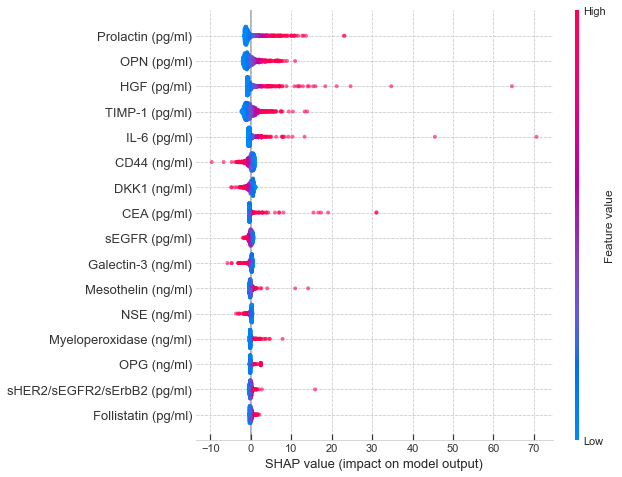

In [46]:
shap.summary_plot(shap_values, X_test,
                  max_display=16, class_names=['Non-cancerous', 'Cancerous'],
                  layered_violin_max_num_bins=20, alpha=0.6)

## 3. Comparision to CancerSEEK
 - plot the ROC curve and calculate the confusion matrix for the predictions
 - do the same for the CancerSEEK predictions
 - compare your model's performance to CancerSEEK performance

### 3./a. Plot confusion matrix and calculate accuracy

In [47]:
# Calculating accuracy and the confusion matrix
accuracy = accuracy_metric(y_test.ravel(), y_pred)
conf_mat = confusion_matrix(y_test.ravel(), y_pred)

In [48]:
classes = classes=['Cancerous', 'Non-cancerous']
title=('Fig. 2. Confusion matrix of the cancer identification\n' +
       'by protein levels.\n' +
       'Accuracy of model is {0:.3f}%'.format(accuracy))

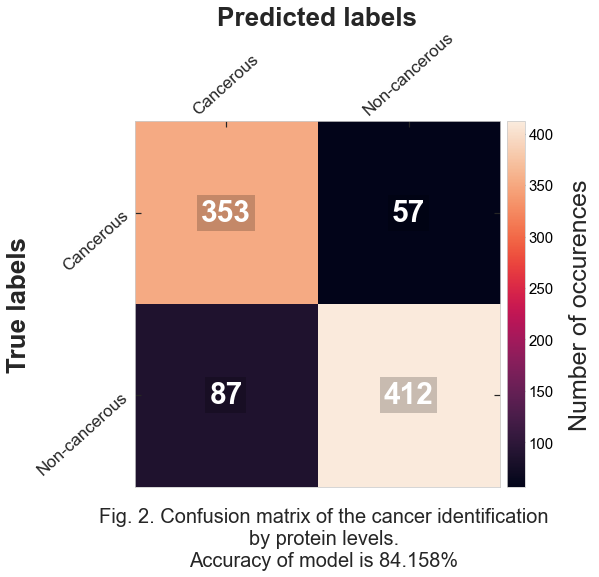

In [49]:
fig, axes = plt.subplots(figsize=(7, 7))
axes.set_aspect('equal')

im = axes.imshow(conf_mat)
# Loop over data dimensions and create text annotations.
for X in range(conf_mat.shape[0]):
    for Y in range(conf_mat.shape[1]):
        axes.text(Y, X, conf_mat[X, Y], fontsize=30,
                  ha='center', va='center', color='white', fontweight='bold', 
                  bbox=dict(color=np.array((0,0,0,0.2)), lw=0)
                 )

ticks = [i for i in range(len(classes))]
axes.set_xticks(ticks)
axes.set_xticklabels(classes, ha='center')
axes.set_yticks(ticks)
axes.set_yticklabels(classes, va='center_baseline')

axes.set_xlabel('Predicted labels', fontsize=axislabelsize, fontweight='bold')
axes.set_ylabel('True labels', fontsize=axislabelsize, fontweight='bold')
axes.tick_params(axis='both', which='major', labelsize=axisticksize, rotation=42)
axes.xaxis.tick_top()
axes.xaxis.set_label_position('top') 

axes.grid(False)

# Create an axis on the right side of `axes`. The width of `cax` will be 5%
# of `axes` and the padding between `cax` and axes will be fixed at 0.1 inch
divider = make_axes_locatable(axes)
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = plt.colorbar(mappable=im, cax=cax)
cbar.ax.tick_params(labelsize=axiscbarfontsize, colors='black')
cbar.set_label('Number of occurences', fontsize=axiscbarfontsize+10, labelpad=15, rotation=90)

plt.suptitle(title,
             fontsize=axistitlesize, y=0.1)

plt.show()

### 3./b. Plot ROC and calculate AOC

In [50]:
fpr, tpr, roc_auc = cal_roc_multi(y_test, y_pred, n_classes=1)

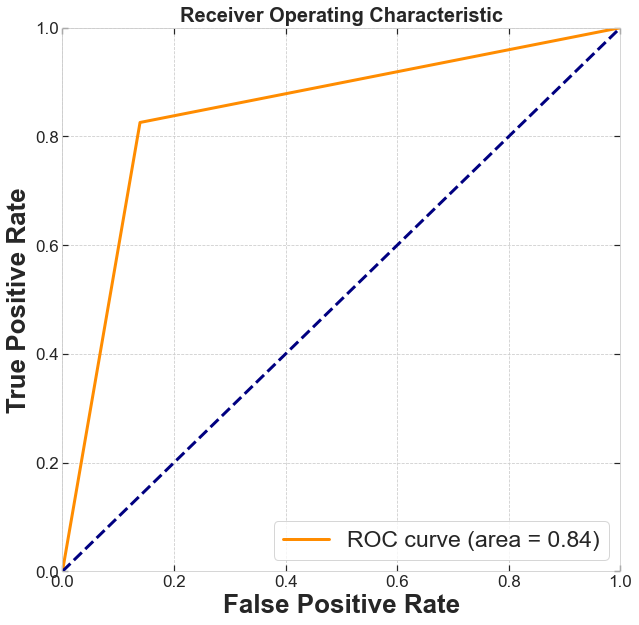

In [52]:
nrows = 1
ncols = 1
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*10, nrows*10))

axes.plot(fpr[0], tpr[0], color='darkorange',
          lw=3, label='ROC curve (area = %0.2f)' % roc_auc[0])
axes.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')

axes.set_xlim([0.0, 1.0])
axes.set_ylim([0.0, 1.0])

axes.set_title('Receiver Operating Characteristic', fontsize=axistitlesize, fontweight='bold')
axes.set_xlabel('False Positive Rate', fontsize=axislabelsize, fontweight='bold')
axes.set_ylabel('True Positive Rate', fontsize=axislabelsize, fontweight='bold')
axes.tick_params(axis='both', which='major', labelsize=axisticksize)

axes.legend(loc='lower right', fontsize=axislegendsize)

plt.show()

## 4. Hepatocellular carcinoma
 - fit a logistic regression (using statsmodels API this time) to predict if a sample has Hepatocellular carcinoma (liver cancer) or not. You need to keep only the liver and the normal samples for this exercise! For fitting use only the first 25 features and all the rows (which are liver or normal)
 - select the 5 best predictor based on P values.
 - Write down the most important features (based on P value) and compare them to the tumor markers that you find on wikipeida https://en.wikipedia.org/wiki/Hepatocellular_carcinoma or other sources!

In [63]:
import statsmodels.api as sm

### 4./a. Logistic regression using `statsmodels`

In [113]:
# Observables are the protein levels
X = df_model[df_model.columns[2:-3]].copy()
# Select only `Normal` and `Liver` tumor types
selection_map = (df['Tumor type'] == 'Normal') | (df['Tumor type'] == 'Liver')
X = X[selection_map][X.columns[:25]]
# Scale features with continuous variables
X = pd.DataFrame(scale_data(X), columns=X.columns)

# The target variable is 'Cancerous'
y = label_binarize(df_model.loc[selection_map, 'Tumor type'], classes=[1, 9])

In [118]:
log_reg = sm.Logit(y, X).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.092691
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  856
Model:                          Logit   Df Residuals:                      831
Method:                           MLE   Df Model:                           24
Date:                Sun, 11 Oct 2020   Pseudo R-squ.:                  0.5425
Time:                        23:39:07   Log-Likelihood:                -79.343
converged:                       True   LL-Null:                       -173.44
Covariance Type:            nonrobust   LLR p-value:                 1.968e-27
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
AFP (pg/ml)                27.8590      2.976      9.360      0.000      22.026  

### 4./b. Select best 5 predictors

In [173]:
from tabulate import tabulate

In [158]:
def results_summary_to_dataframe(results):
    '''take the result of an statsmodel results table and transforms it into a dataframe'''
    pvals = results.pvalues
    coeff = results.params
    conf_lower = results.conf_int()[0]
    conf_higher = results.conf_int()[1]

    results_df = pd.DataFrame({"pvals":pvals,
                               "coeff":coeff,
                               "conf_lower":conf_lower,
                               "conf_higher":conf_higher
                                })

    #Reordering...
    results_df = results_df[["coeff","pvals","conf_lower","conf_higher"]]
    return results_df

In [160]:
p_values = log_reg.pvalues

In [168]:
p_values_val, p_values_key = zip(*sorted(zip(list(p_values.values), list(p_values.index))))

In [179]:
N = 5
print('Most 5 impactful biomarkers:\n'+
      '----------------------------')
print(tabulate([[k, v] for (k, v) in zip(p_values_key[-N:][::-1], p_values_val[-N:][::-1])], headers=['Biomarker', 'Value']))

Most 5 impactful biomarkers:
----------------------------
Biomarker              Value
------------------  --------
G-CSF (pg/ml)       0.821528
CA 15-3 (U/ml)      0.787116
Leptin (pg/ml)      0.746526
Midkine (pg/ml)     0.70712
CYFRA 21-1 (pg/ml)  0.642847


## 5. Multiclass classification
 - Again, using every second datapoint train a logistic regression (sklearn API) to predict the tumor type. It is a multiclass classification problem.
 - Generate prediction for the rest of the dataset and show the confusion matrix for the predictions!
 - Plot the ROC curves for the different cancer types on the same plot! 
 - Intepret your results. Which cancer type can be predicted the most reliably?

### 5./a. Generate predictions

In [53]:
def fit_classifier(X, y):
    
    # Split the data into train and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state=0)

    # Build the model with Logistic Regression wrapped inside an OVR strategy
    classifier = OneVsRestClassifier(LogisticRegression(penalty='l2', max_iter=1000, random_state=0))
    classifier.fit(X_train, y_train)
    
    return classifier, X_train, X_test, y_train, y_test

In [54]:
# Observables are the protein levels
X = df_model[df_model.columns[2:-3]].copy()
# Scale features with continuous variables
X = pd.DataFrame(scale_data(X), columns=X.columns)

# The target variable is 'Tumor type'
y = df_model['Tumor type']
y = label_binarize(y, classes=list(set(df_model['Tumor type'])))

In [55]:
classifier, X_train, X_test, y_train, y_test = fit_classifier(X, y)
y_pred = classifier.decision_function(X_test)

In [56]:
shap_values = shap.LinearExplainer(classifier, X_train).shap_values(X_test)

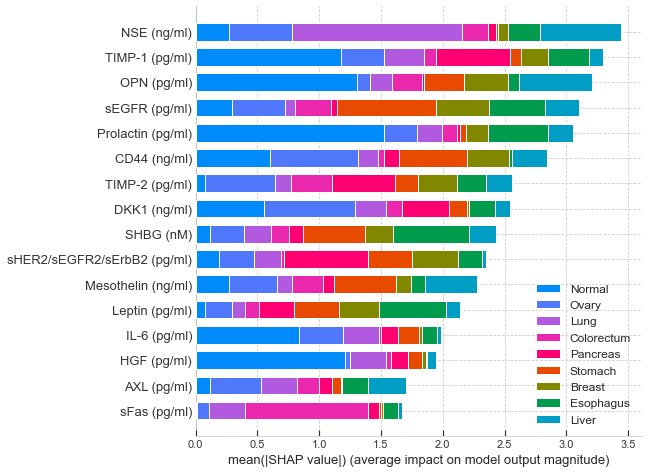

In [57]:
shap.summary_plot(shap_values, X_test,
                  max_display=16, class_names=list(df['Tumor type'].value_counts().index),
                  layered_violin_max_num_bins=20, alpha=0.6)

### 5./b. Confusion matrix and accuracy of predictions

In [58]:
accuracy = accuracy_metric(y_test=y_test, y_pred=y_pred)
conf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

In [59]:
title=('Fig. 3. Confusion matrix of the tumor type recognition\n' +
       'Accuracy of model is {0:.3f}%'.format(accuracy))
classes = list(tumor_dict.values())

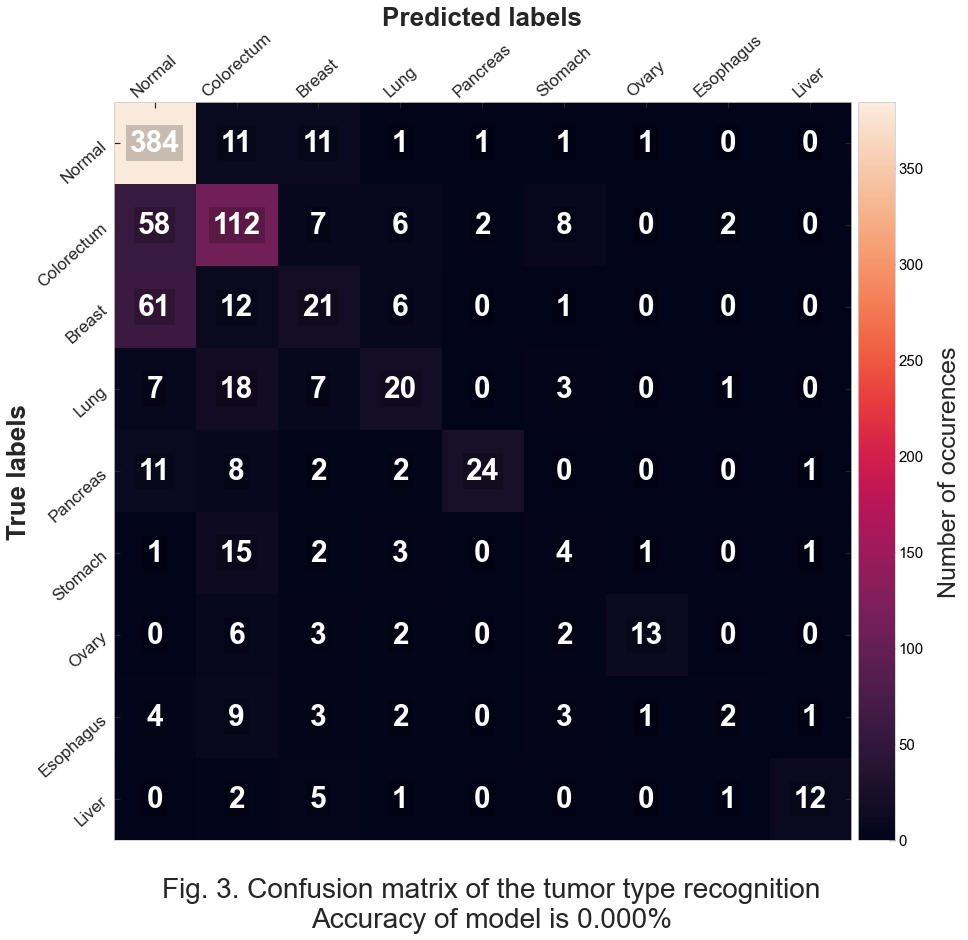

In [60]:
fig, axes = plt.subplots(figsize=(14, 14))
axes.set_aspect('equal')

im = axes.imshow(conf_mat)
# Loop over data dimensions and create text annotations.
for X in range(conf_mat.shape[0]):
    for Y in range(conf_mat.shape[1]):
        axes.text(Y, X, conf_mat[X, Y], fontsize=30,
                  ha='center', va='center', color='white', fontweight='bold', 
                  bbox=dict(color=np.array((0,0,0,0.2)), lw=0)
                 )

ticks = [i for i in range(len(classes))]
axes.set_xticks(ticks)
axes.set_xticklabels(classes, ha='center')
axes.set_yticks(ticks)
axes.set_yticklabels(classes, va='center_baseline')

axes.set_xlabel('Predicted labels', fontsize=axislabelsize, fontweight='bold')
axes.set_ylabel('True labels', fontsize=axislabelsize, fontweight='bold')
axes.tick_params(axis='both', which='major', labelsize=axisticksize, rotation=42)
axes.xaxis.tick_top()
axes.xaxis.set_label_position('top') 

axes.grid(False)

# Create an axis on the right side of `axes`. The width of `cax` will be 5%
# of `axes` and the padding between `cax` and axes will be fixed at 0.1 inch
divider = make_axes_locatable(axes)
cax = divider.append_axes('right', size='5%', pad=0.1)
cbar = plt.colorbar(mappable=im, cax=cax)
cbar.ax.tick_params(labelsize=axiscbarfontsize, colors='black')
cbar.set_label('Number of occurences', fontsize=axiscbarfontsize+10, labelpad=15, rotation=90)

plt.suptitle(title,
             fontsize=axistitlesize+8, y=0.1)

plt.show()

### 5./c. ROC curve of different classes

In [61]:
fpr, tpr, roc_auc = cal_roc_multi(y_test, y_pred, n_classes=len(set(df_model['Tumor type'])))

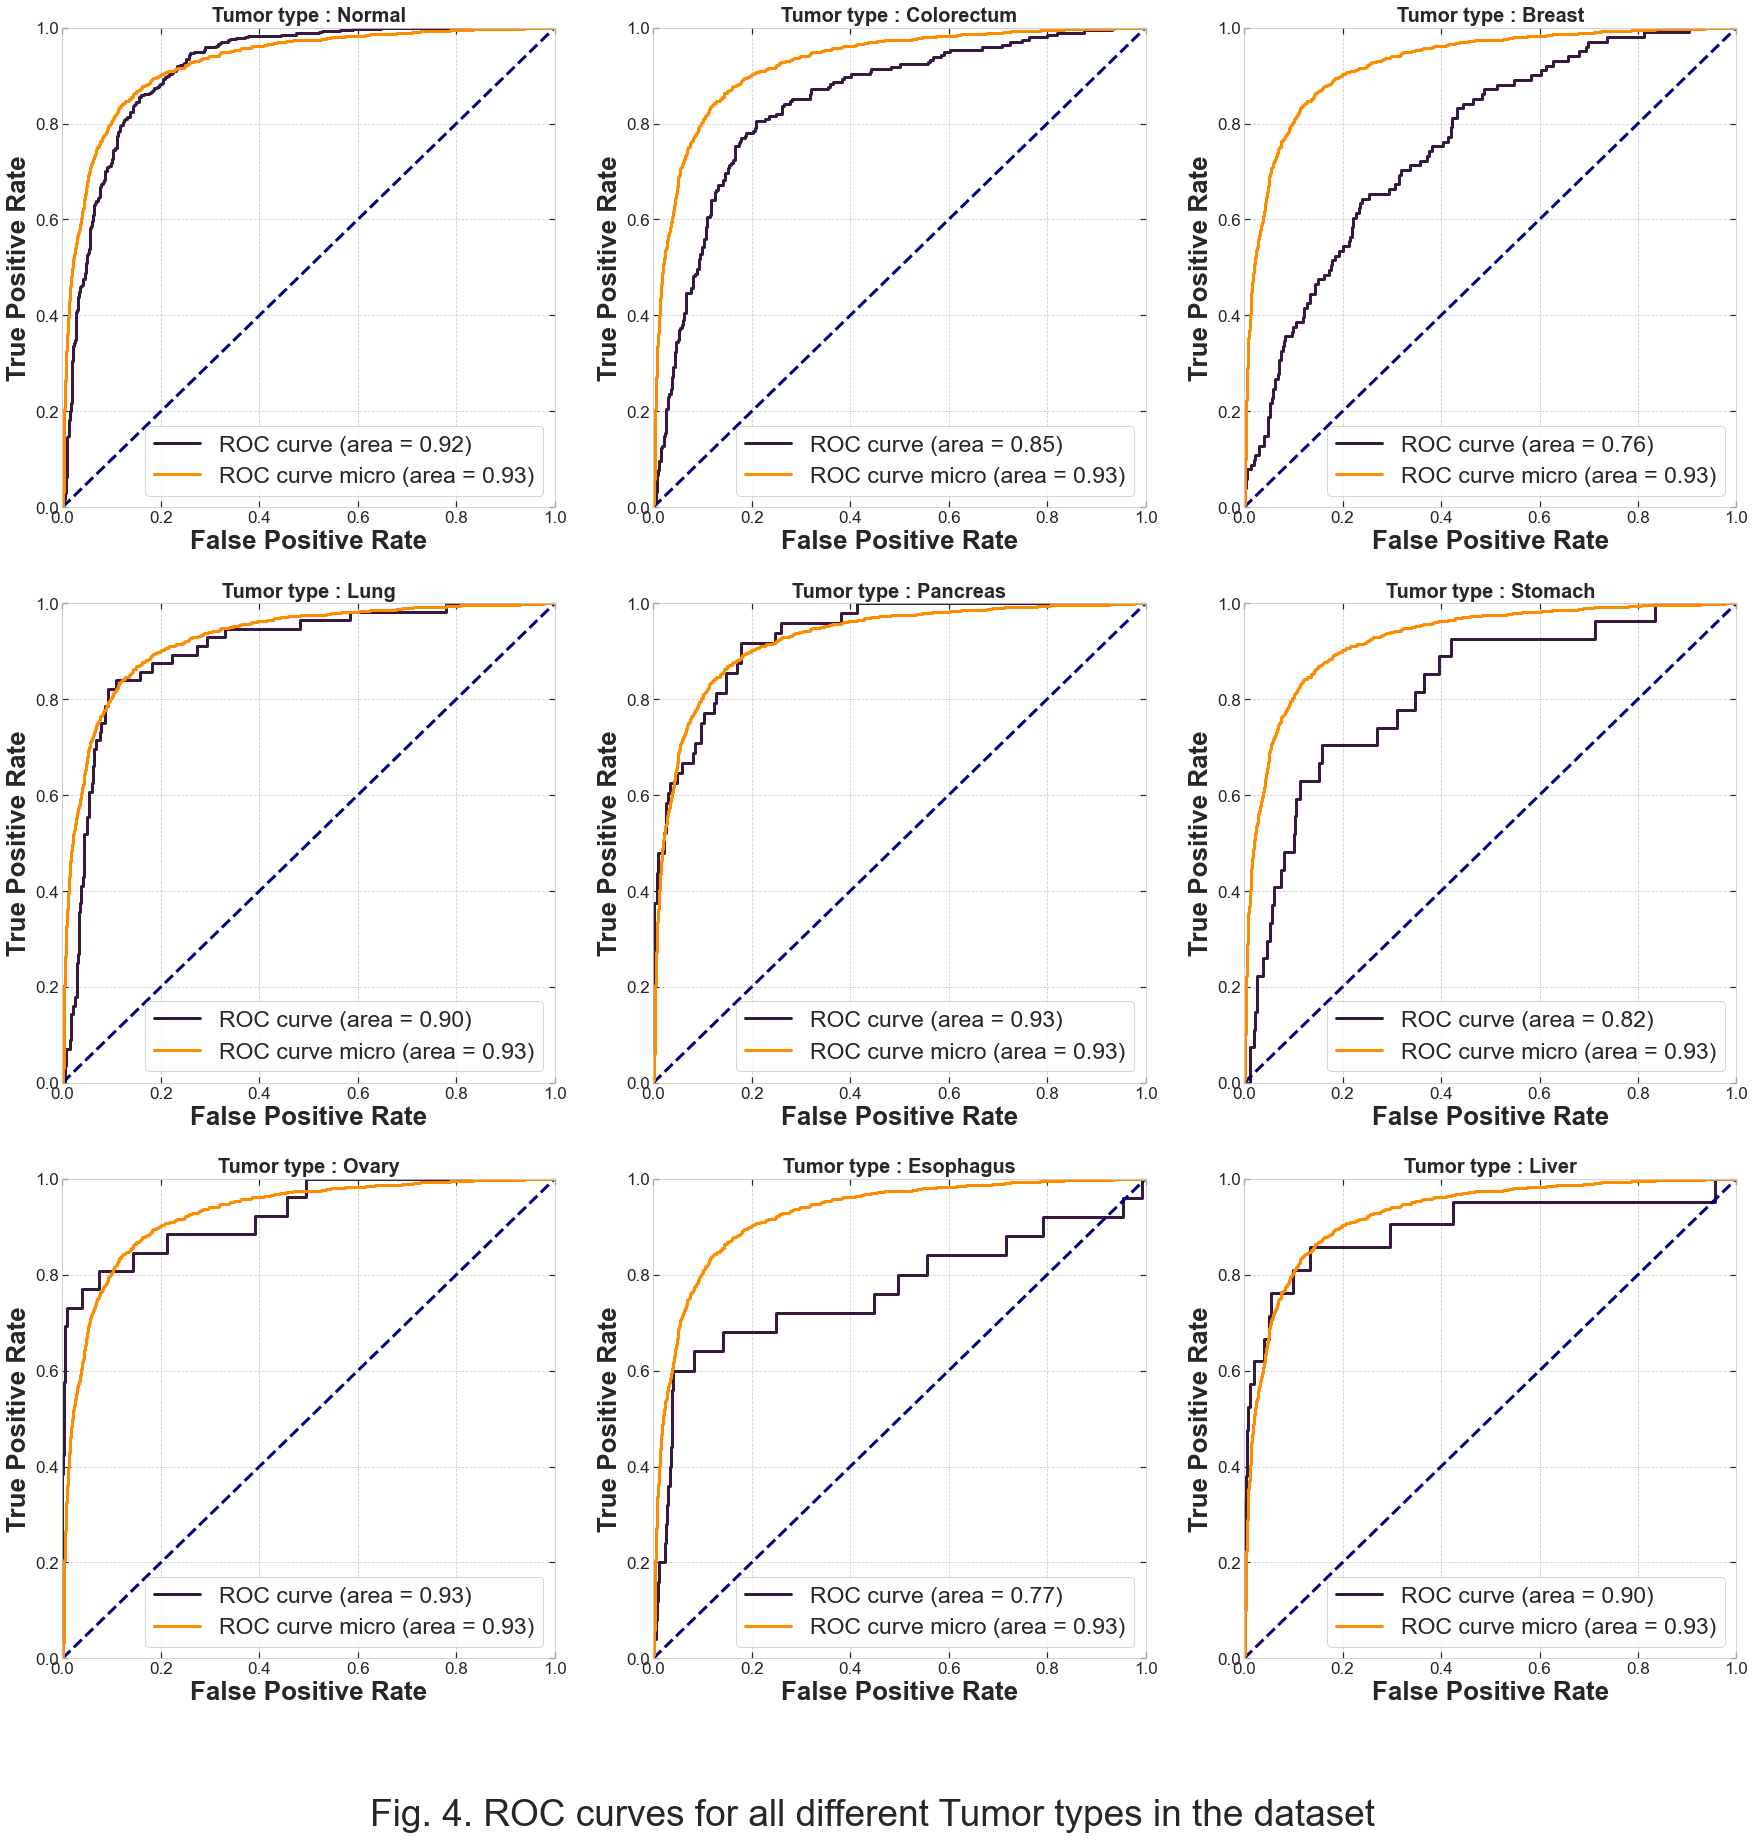

In [62]:
nrows = 3
ncols = 3
fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*10, nrows*10))

for k in list(fpr.keys())[:-1]:
    i = k // nrows
    j = k % ncols
    ax = axes[i][j]
    ax.plot(fpr[k], tpr[k],
              lw=3, label='ROC curve (area = %0.2f)' % roc_auc[k])
    ax.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
    ax.plot(fpr['micro'], tpr['micro'], color='darkorange',
            lw=3, label='ROC curve micro (area = %0.2f)' % roc_auc['micro'])

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])

    ax.set_title('Tumor type : {0}'.format(tumor_dict[k+1]), fontsize=axistitlesize, fontweight='bold')
    ax.set_xlabel('False Positive Rate', fontsize=axislabelsize, fontweight='bold')
    ax.set_ylabel('True Positive Rate', fontsize=axislabelsize, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=axisticksize)

    ax.legend(loc='lower right', fontsize=axislegendsize)

plt.suptitle('Fig. 4. ROC curves for all different Tumor types in the dataset',
             fontsize=axistitlesize+17, y=0.06)
    
plt.show()

It seems to be, that pancreas and ovary cancer are identified the most reliably, as indicated by the area under the ROC curve. Not-so surprisingly, the reliable detection of breast cancer is the lowest by far.

### Hints:
 - On total you can get 10 points for fully completing all tasks.
 - Decorate your notebook with, questions, explanation etc, make it self contained and understandable!
 - Comments you code when necessary
 - Write functions for repetitive tasks!
 - Use the pandas package for data loading and handling
 - Use matplotlib and seaborn for plotting or bokeh and plotly for interactive investigation
 - Use the scikit learn package for almost everything
 - Use for loops only if it is really necessary!
 - Code sharing is not allowed between student! Sharing code will result in zero points.
 - If you use code found on web, it is OK, but, make its source clear!